In [3]:
import pandas as pd

In [4]:
df=pd.read_csv('Reviews[1].csv')
df=df.head(50000)


In [39]:
df.shape

(50000, 10)

In [6]:
df.shape

(50000, 10)

## Step 0. Read in Data and NLTK Basics

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

## Quick EDA

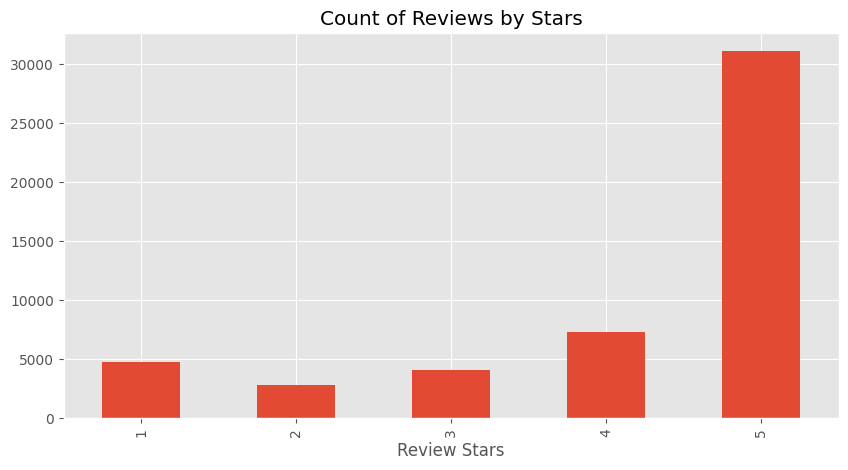

In [8]:
ax = df['Score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

## Basic NLTK

In [9]:
example=df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [10]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\eesha/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [11]:
tokens=nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [12]:
nltk.download('averaged_perceptron_tagger_eng')


[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\eesha/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [13]:
tagged=nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [14]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


## Step 1. VADER Seniment Scoring¶
We will use NLTK's SentimentIntensityAnalyzer to get the neg/neu/pos scores of the text.

This uses a "bag of words" approach:
1. Stop words are removed
2. each word is scored and combined to a total score.

*what's vader?:*

*valence aware dictionary and sentiment reasoner*

This basically takes all the words in our sentence and it has a value of positive, negative, or neutral for that sentence, but this approach does not takes into consideration the relationship between the words. 

In [15]:

from nltk.sentiment import SentimentIntensityAnalyzer

from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()


In [16]:
sia.polarity_scores('I am so happy!')


{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [17]:
sia.polarity_scores('This is the worst thing ever.')


{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [18]:
sia.polarity_scores(example)


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [19]:
# Run the polarity score on the entire dataset
res = {}
for row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [24]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [25]:
# Now we have sentiment score and metadata
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Plot VADER results

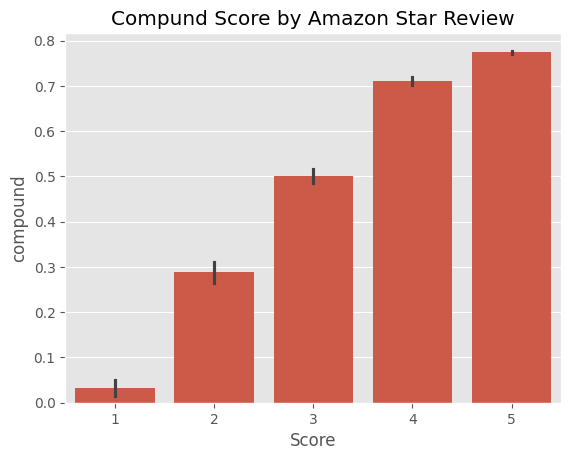

In [26]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

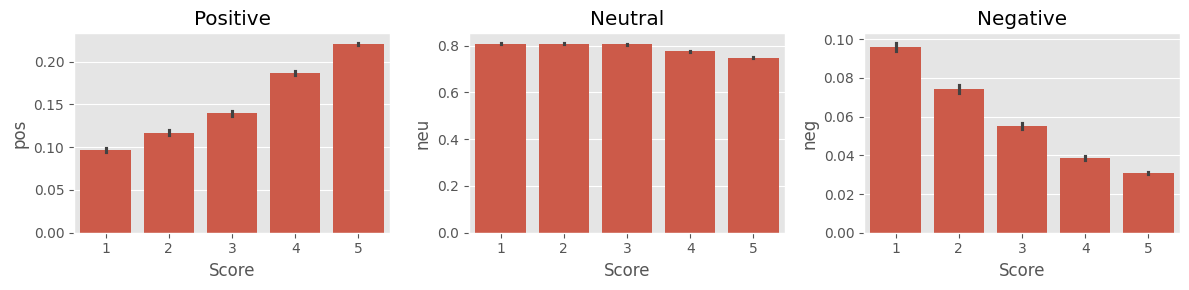

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

In [ ]:
## using tfidf and ml models for the analysis

In [ ]:
##

In [59]:
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Map Scores to Sentiment
def map_score_to_sentiment(score):
    if score in [1, 2]:
        return 'Negative'
    elif score == 3:
        return 'Neutral'
    elif score in [4, 5]:
        return 'Positive'

df['Sentiment'] = df['Score'].apply(map_score_to_sentiment)

# Text Cleaning Function
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove non-alphanumeric characters
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

df['Cleaned_Text'] = df['Text'].apply(clean_text)

# Prepare features and labels
X = df['Cleaned_Text']
y = df['Sentiment']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# TF-IDF Vectorization
tfidf = TfidfVectorizer(stop_words='english', max_df=0.85, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Train Logistic Regression
model = LogisticRegression(max_iter=200, C=1.0, penalty='l2')
model.fit(X_train_tfidf, y_train)

# Evaluate the model
y_pred = model.predict(X_test_tfidf)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.8433
              precision    recall  f1-score   support

    Negative       0.78      0.57      0.66      1545
     Neutral       0.59      0.08      0.15       838
    Positive       0.85      0.98      0.91      7617

    accuracy                           0.84     10000
   macro avg       0.74      0.55      0.57     10000
weighted avg       0.82      0.84      0.81     10000

[[ 881   24  640]
 [ 138   71  629]
 [ 111   25 7481]]


In [63]:
# Step 6: Train a Naive Bayes model
model1 = MultinomialNB()
model1.fit(X_train_tfidf, y_train)

# Step 7: Evaluate the model
y_pred = model1.predict(X_test_tfidf)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Step 8: Predict new samples
new_texts = ["I love this product!", "This is the worst experience ever."]
new_texts_tfidf = tfidf.transform(new_texts)
predictions = model1.predict(new_texts_tfidf)
print(predictions)

Accuracy: 0.7617
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00      1545
     Neutral       0.00      0.00      0.00       838
    Positive       0.76      1.00      0.86      7617

    accuracy                           0.76     10000
   macro avg       0.25      0.33      0.29     10000
weighted avg       0.58      0.76      0.66     10000

[[   0    0 1545]
 [   0    0  838]
 [   0    0 7617]]
['Positive' 'Positive']


C:\Users\eesha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\eesha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\eesha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [67]:
from sklearn.pipeline import Pipeline
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Define a pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('logreg', LogisticRegression(solver='liblinear'))
])

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'tfidf__max_df': uniform(0.5, 0.5),  # Range from 0.5 to 1.0
    'tfidf__min_df': [1, 3, 5],
    'tfidf__ngram_range': [(1, 1), (1, 2)],  # Unigrams and bigrams
    'logreg__C': uniform(0.01, 10.0),  # Range from 0.01 to 10
    'logreg__penalty': ['l1', 'l2']
}

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=50, 
                                   cv=5, n_jobs=-1, verbose=1, random_state=42)
random_search.fit(X_train, y_train)

# Evaluate the best model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
print(f"Best Parameters: {random_search.best_params_}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'logreg__C': 9.709098521619943, 'logreg__penalty': 'l2', 'tfidf__max_df': 0.9692763545078751, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 2)}
Accuracy: 0.8613
              precision    recall  f1-score   support

    Negative       0.76      0.66      0.71      1545
     Neutral       0.61      0.22      0.33       838
    Positive       0.89      0.97      0.93      7617

    accuracy                           0.86     10000
   macro avg       0.75      0.62      0.66     10000
weighted avg       0.84      0.86      0.84     10000

[[1027   62  456]
 [ 154  188  496]
 [ 163   56 7398]]
